In [2]:
import os
import pandas as pd
import re
from tqdm import tqdm
from utils import load_jsonl_iteratively

In [66]:
def process_df(lang):
    iter_losses = []
    if lang == "ja":
        task_names = {
            'ja_knowledge_memorization': 'Memorization',
            'ja_knowledge_generalization': 'Intralingual',
            'en_knowledge_generalization': 'Interlingual'
        }
        ROOT = "/data/xzhao/experiments/roman-pretrain/exps/exp1-multi-ja/hf_models"
    else:
        task_names = {
            'en_knowledge_memorization': 'Memorization',
            'en_knowledge_generalization': 'Intralingual',
            'ja_knowledge_generalization': 'Interlingual'
        }
        ROOT = "/data/xzhao/experiments/roman-pretrain/exps/exp1-multi-en_jstage/hf_models"
    for fn in tqdm(os.listdir(ROOT)):
        if not fn.startswith("iter_"):
            continue

        iter_info = {task: [] for task in task_names}
        num_iter = int(re.match("iter_(\d+)", fn).group(1))
        if num_iter > 0 and num_iter < 1000:
            continue
        
        fn = os.path.join(ROOT, fn, "adaxeval.jsonl")
        if not os.path.exists(fn):
            continue
        
        task2sample_ids = {task: set() for task in task_names}
        for item in load_jsonl_iteratively(fn):
            sample = item['sample']
            if 'dataset' not in sample:
                continue
            task = sample['dataset']
            if task not in task_names:
                continue
            
            sample_id = sample['sample_id']
            if sample_id in task2sample_ids[task]:
                continue
            
            task2sample_ids[task].add(sample_id)

            answer_idx = int(sample['answer_idx'])
            valid_loss = item['losses'][answer_idx]
            valid_normloss = item['norm_losses'][answer_idx]
            invalid_loss = sum([item['losses'][i] for i in range(4) if i != answer_idx])/3
            invalid_normloss = sum([item['norm_losses'][i] for i in range(4) if i != answer_idx])/3

            iter_info[task].append((sample_id, valid_loss, valid_normloss, invalid_loss, invalid_normloss))

        for task, losses in iter_info.items():
            sample_id, valid_loss, valid_normloss, invalid_loss, invalid_normloss = list(zip(*losses))
            iter_losses.append({
                'sample_id': sample_id,
                'num_iter': num_iter,
                'task': task_names[task],
                'valid_loss': sum(valid_loss)/len(valid_loss),
                'valid_normloss': sum(valid_normloss)/len(valid_normloss),
                'invalid_loss': sum(invalid_loss)/len(invalid_loss),
                'invalid_normloss': sum(invalid_normloss)/len(invalid_normloss),
                'valid_loss_ratio': sum(valid_loss) / (sum(valid_loss) + 3 * sum(invalid_loss)),
                'valid_normloss_ratio': sum(valid_normloss) / (sum(valid_normloss) + 3 * sum(invalid_normloss)),
                'num_sample': len(losses),
            })
    df = pd.DataFrame(iter_losses)
    df = df[(df['num_iter'] >= 1000) | (df['num_iter'] == 0)]
    return df

en_df = process_df("en")
ja_df = process_df("ja")

100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os

def plot_loss_2panels(df_left, df_right, report_ratio):
    """
    Two side-by-side loss plots with shared y-axis.
    Legend on top and global title below.
    """
    sns.set_theme(style="whitegrid", font_scale=1.1)
    fontsize = 12
    palette = {
        'Memorization': '#F9A037',
        'Intralingual': '#3D7AB3',
        'Interlingual': '#6AB187'
    }
    task_order = ["Memorization", "Intralingual", "Interlingual"]

    fig, axes = plt.subplots(1, 2, figsize=(7.5, 3.25), sharey=True, constrained_layout=True)

    def _plot(ax, df, is_left, subtitle):
        y_colum = 'valid_normloss' if not report_ratio else "valid_normloss_ratio"
        sns.lineplot(
            data=df, x='num_iter', y=y_colum,
            hue='task', hue_order=task_order,
            linewidth=3, marker='o', markersize=6,
            palette=palette, ax=ax
        )

        # epoch markers
        ax.axvline(x=int(max(df['num_iter'])/4), color='#FF0000', linestyle='--', lw=1.5, label='1st Epoch')
        # ax.axvline(x=int(max(df['num_iter'])/2), color='#0000FF', linestyle='--', lw=1.5, label='2nd Epoch')

        ax.set_xlabel("Iteration Number", fontsize=18)
        if is_left:
            ax.set_ylabel("Cross-entropy Loss", fontsize=18)
        else:
            ax.set_ylabel("")
        ax.tick_params(axis='both', labelsize=16)
        ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
        ax.set_title(subtitle, fontsize=17, weight='bold')

        ax.xaxis.set_major_formatter(FuncFormatter(
            lambda x, _: '0' if x == 0 else f'{int(x/1000)}K'
        ))

    _plot(axes[0], df_left, True, "English Training")
    _plot(axes[1], df_right, False, "Japanese Training")

    # remove per-panel legends
    for ax in axes:
        leg = ax.get_legend()
        if leg: leg.remove()

    # combine legend and move to top
    handles, labels = axes[0].get_legend_handles_labels()
    # handles = [handles[0], handles[3], handles[1], handles[4], handles[2]]
    # labels = [labels[0], labels[3], labels[1], labels[4], labels[2]]

    if not report_ratio:
        fig.legend(
            handles, labels,
            loc='upper center', bbox_to_anchor=(0.51, 1.25),
            ncol=2, fontsize=17
        )

    plt.tight_layout()
    result_dir = "../figures"
    if not report_ratio:
        plt.savefig(
            os.path.join(result_dir, "merged-monolingual-loss.pdf"),
            dpi=300, bbox_inches="tight")
    else:
        plt.savefig(
            os.path.join(result_dir, "merged-monolingual-lossratio.pdf"),
            dpi=300, bbox_inches="tight")
    


/tmp/ipykernel_1773440/2062676091.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


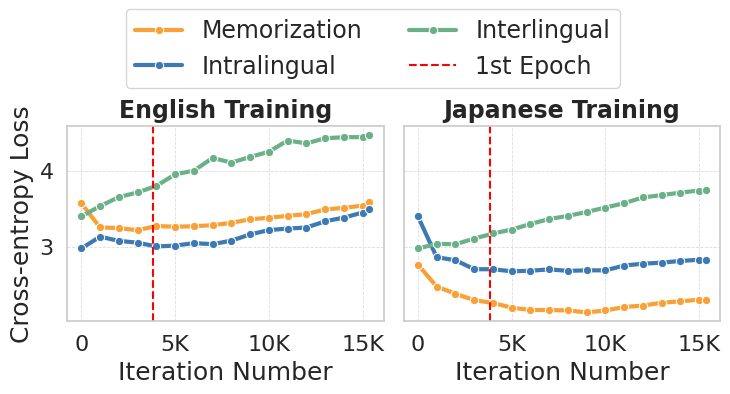

In [90]:
plot_loss_2panels(en_df, ja_df, report_ratio=False)

/tmp/ipykernel_1773440/2062676091.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


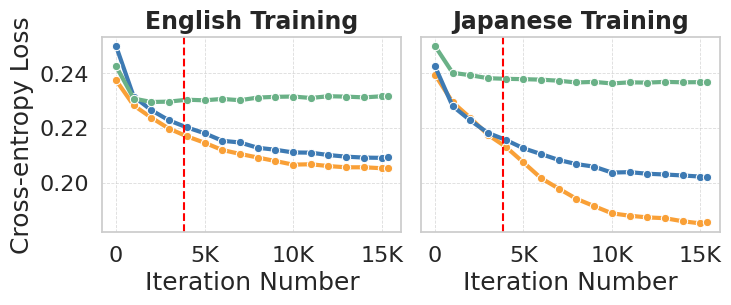

In [91]:
plot_loss_2panels(en_df, ja_df, report_ratio=True)